<a href="https://colab.research.google.com/github/AshimR/web3j-workshop/blob/master/SVM_NN_text_embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas --quiet
!pip install transformers --quiet
!pip install optuna --quiet
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna # for searching best hyperparameter
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import shap
from google.colab import files
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
file = files.upload()

Saving sym_w_embeddings_corrected.csv to sym_w_embeddings_corrected.csv


this part is used for feature scaling and wont be needed in the main model

In [ ]:
# Load the dataset to preprocess it for text embedding and semantic search usage
data = pd.read_csv('/content/symbipredict_2022.csv')

# Creating a text description for each row in the dataset by concatenating symptom names if present (1)
def create_symptom_description(row):
    symptoms = [col.replace('_', ' ') for col in row.index if row[col] == 1]
    return ', '.join(symptoms)

# Apply the function to each row in the DataFrame
data['symptom_description'] = data.apply(create_symptom_description, axis=1)

# Check the modified DataFrame and export it to a CSV file for verification
data.to_csv('/content/processed_symbipredict_2022.csv', index=False)
data.head(), data['symptom_description'].head()


(   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
 0        1          1                     1                    0          0   
 1        0          1                     1                    0          0   
 2        1          0                     1                    0          0   
 3        1          1                     0                    0          0   
 4        1          1                     1                    0          0   
 
    chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  scurring  \
 0       0           0             0        0                 0  ...         0   
 1       0           0             0        0                 0  ...         0   
 2       0           0             0        0                 0  ...         0   
 3       0           0             0        0                 0  ...         0   
 4       0           0             0        0                 0  ...         0   
 
    skin_peeling  silver

In [ ]:
# data_frame.to_csv('/content/embd_symbipredict_2022.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath)

# Plot the distribution of each disease (prognosis)
def plot_disease_distribution(df):
    plt.figure(figsize=(12, 8))
    disease_counts = df['prognosis'].value_counts()
    sns.barplot(y=disease_counts.index, x=disease_counts.values, palette='viridis')
    plt.title('Disease Distribution in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel('Diseases')
    plt.show()

# Plot the prevalence of symptoms in the dataset
def plot_symptom_prevalence(df):
    symptoms = df.columns[:-1]  # exclude the last column which is prognosis
    symptom_counts = df[symptoms].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 10))
    sns.barplot(y=symptom_counts.index[:30], x=symptom_counts.values[:30], palette='viridis')  # Top 30 symptoms
    plt.title('Top 30 Common Symptoms in Dataset')
    plt.xlabel('Frequency of Symptoms')
    plt.ylabel('Symptoms')
    plt.show()

# Plot a heatmap of symptom correlations
def plot_symptom_correlation(df):
    symptoms = df.columns[:-1]  # exclude the last column which is prognosis
    correlation_matrix = df[symptoms].corr()
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=False)
    plt.title('Correlation Matrix of Symptoms')
    plt.show()

# Main function to run the EDA
def run_eda(filepath):
    df = load_data(filepath)
    plot_disease_distribution(df)
    plot_symptom_prevalence(df)
    plot_symptom_correlation(df)

In [ ]:
data_frame = data[['symptom_description','prognosis']]

In [ ]:
# Compute descriptive statistics for the 'prognosis' column to see the distribution of diseases
disease_distribution = data_frame['prognosis'].value_counts()

# Display the disease distribution
disease_distribution

This part was done to create a dataset with embeddings

In [ ]:
# Initialize tokenizer and model from Hugging Face's Transformers
emb_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
emb_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function to generate embeddings for a given text
def generate_embeddings(text):
    encoded_input = emb_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = emb_model(**encoded_input)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Apply the function to generate embeddings for the 'symptom_description' column
data_frame['embeddings'] = data_frame['symptom_description'].apply(generate_embeddings)

# Optionally save the new dataframe with embeddings to a new CSV for further use
data_frame.to_csv('sym_w_embeddings2.csv', index=False)

# Print some of the generated embeddings to confirm they are correct
print(data_frame[['symptom_description', 'embeddings']].head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

<ipython-input-30-ee7ec519fda6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['embeddings'] = data_frame['symptom_description'].apply(generate_embeddings)


                                 symptom_description  \
0  itching, skin rash, nodal skin eruptions, disc...   
1  skin rash, nodal skin eruptions, dischromic  p...   
2  itching, nodal skin eruptions, dischromic  pat...   
3            itching, skin rash, dischromic  patches   
4           itching, skin rash, nodal skin eruptions   

                                          embeddings  
0  [0.300389, 0.010864246, -0.40300804, 0.2143276...  
1  [0.39868072, -0.112185195, -0.33901146, 0.1459...  
2  [0.31049445, 0.011516023, -0.41578156, 0.19552...  
3  [0.35473484, -0.046607442, -0.38146266, 0.2751...  
4  [0.37643713, 0.08506728, -0.40587324, 0.328377...  


In [ ]:
# Assuming embeddings are generated as numpy arrays (from your previous code snippet)
data_frame['embeddings'] = data_frame['symptom_description'].apply(lambda x: ','.join(map(str, generate_embeddings(x))))

# Now save to CSV
data_frame.to_csv('sym_w_embeddings_corrected.csv', index=False)

<ipython-input-45-964644922b94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['embeddings'] = data_frame['symptom_description'].apply(lambda x: ','.join(map(str, generate_embeddings(x))))


In [ ]:
def convert_to_ndarray(string):
    try:
        return np.array(list(map(float, string.split(','))))
    except ValueError:
        return np.array([])  # Return an empty array if conversion fails

# Load your dataframe
data_frame = pd.read_csv('/content/sym_w_embeddings_corrected.csv')
data_frame['embeddings'] = data_frame['embeddings'].apply(convert_to_ndarray)

# Verify the types again
print(data_frame['embeddings'].apply(type).unique())  # Should show <class 'numpy.ndarray'>


[<class 'numpy.ndarray'>]


In [ ]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

In [ ]:
# Assuming 'embeddings' column contains the embeddings and is in an appropriate format
X = list(data_frame['embeddings'])
y = data_frame['prognosis']
X_scaled = scaler.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [ ]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create training and testing datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Update dataloaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

Simple feedforward neural network (Multilayer Perceptron or MLP)

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
# Setup the SVM model
svm_model = svm.SVC(kernel='linear', C = 0.1785379499667778)

In [ ]:
# Define the neural network architecture
class DiseasePredictor(nn.Module):
    def __init__(self):
        """
        The main model to predict diseases
        """
        super(DiseasePredictor, self).__init__()
        self.fc1 = nn.Linear(in_features=768, out_features=462)
        self.fc2 = nn.Linear(462, 462)  # Second hidden layer
        self.fc3 = nn.Linear(462, 462)  # Third hidden layer
        self.output = nn.Linear(462, 41)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0015) # Dropout layer very small
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.output(x)
        x = self.log_softmax(x)
        return x

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [ ]:
# Initialize the network, loss function, and optimizer
predict_model = DiseasePredictor()
criterion = LabelSmoothingCrossEntropy(smoothing = 0.1) # to prevent overfitting
optimizer = optim.Adam(predict_model.parameters(), lr = 0.0006312703277951093) # tuned
scheduler = ExponentialLR(optimizer, gamma = 0.9053013456459507) # to update lerning rate

In [ ]:
# Training loop for neural network
def train_model():
  predict_model.train()
  for epoch in range(55):  # 55 , based on the best result produced during hypertuning
      for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = predict_model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      scheduler.step()
      print(f"Epoch {epoch+1}, Loss: {loss.item()}")
  return predict_model

In [ ]:
trained_model = train_model()

Epoch 1, Loss: 0.6941301822662354
Epoch 2, Loss: 0.6944928765296936
Epoch 3, Loss: 0.6940318942070007
Epoch 4, Loss: 0.6941406726837158
Epoch 5, Loss: 0.6940476894378662
Epoch 6, Loss: 0.6942513585090637
Epoch 7, Loss: 0.6940442323684692
Epoch 8, Loss: 0.6940886378288269
Epoch 9, Loss: 0.6940945386886597
Epoch 10, Loss: 0.6940370798110962
Epoch 11, Loss: 0.6941156387329102
Epoch 12, Loss: 0.6940478086471558
Epoch 13, Loss: 0.6940494775772095
Epoch 14, Loss: 0.6942534446716309
Epoch 15, Loss: 0.6940634250640869
Epoch 16, Loss: 0.6955879926681519
Epoch 17, Loss: 0.6941063404083252
Epoch 18, Loss: 0.6940407156944275
Epoch 19, Loss: 0.6941575407981873
Epoch 20, Loss: 0.6940573453903198
Epoch 21, Loss: 0.6942717432975769
Epoch 22, Loss: 0.6941140294075012
Epoch 23, Loss: 0.6940861344337463
Epoch 24, Loss: 0.6941143870353699
Epoch 25, Loss: 0.6941884756088257
Epoch 26, Loss: 0.6940481662750244
Epoch 27, Loss: 0.6940653920173645
Epoch 28, Loss: 0.6940255165100098
Epoch 29, Loss: 0.69408679008

In [ ]:
# Trianing for svm
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Accuracy
svm_accuracy = accuracy_score(y_test, y_pred)


# Precision
svm_precision = precision_score(y_test, y_pred, average='macro')
# Recall
svm_recall = recall_score(y_test,y_pred ,average='macro')
# F1 score
svm_f1 = f1_score(y_test,y_pred,average='macro')

print(f'Accuracy: {svm_accuracy:.2f}, Precision {svm_precision:.2f},  Recall {svm_recall:.2f} and F1 score {svm_f1:.2f}')
# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def objective_svm(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)

    if kernel in ['rbf', 'sigmoid']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
        svm = SVC(kernel=kernel, C=C, gamma=gamma)
    elif kernel == 'poly':
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
        degree = trial.suggest_int('degree', 1, 5)
        svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
    else:
        svm = SVC(kernel=kernel, C=C)

    score = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=50)

print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_score_)


[I 2024-04-22 12:47:25,958] A new study created in memory with name: no-name-79b45ea6-fe26-4a74-ac6f-ab9ef89dd023
<ipython-input-7-7785bead97cc>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[I 2024-04-22 12:47:29,600] Trial 0 finished with value: 1.0 and parameters: {'k

Best hyperparameters:  {'kernel': 'linear', 'C': 0.1785379499667778}


In [ ]:
# to find the best hyperparameters for nn

def objective(trial):
    # Define the hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 50, 500)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    decay = trial.suggest_uniform('decay', 0.8, 0.999)  # Learning rate decay
    num_epochs = trial.suggest_int('num_epochs', 10, 100)  # Dynamic number of epochs
    batch_size = trial.suggest_int('batch_size', 8, 64)  # Dynamic batch size

    # Model definition based on hyperparameters
    model = nn.Sequential()
    for i in range(num_layers):
        model.add_module(f"linear_{i}", nn.Linear(in_features=768 if i == 0 else num_units, out_features=num_units))
        model.add_module(f"relu_{i}", nn.ReLU())
        model.add_module(f"dropout_{i}", nn.Dropout(p=dropout_rate))
    model.add_module("output", nn.Linear(in_features=num_units, out_features=len(set(y))))
    model.add_module("softmax", nn.LogSoftmax(dim=1))

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    scheduler = ExponentialLR(optimizer, gamma = decay) # to update lerning rate

    # Training loop
    for epoch in range(num_epochs):
      for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      scheduler.step()
      # to evaluate
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)
    return loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Run 100 different trials

print("Best hyperparameters: ", study.best_params)

In [ ]:
def evaluate_model(predict_model, test_loader):
    predict_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = predict_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    print("Classification Report:\n", class_report)

# Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

# Create test_loader with correct configurations similar to train_loader
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=64, shuffle=False)

# Evaluate the model
evaluate_model(trained_model, test_loader)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        29
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        31
          16       1.00      1.00      1.00        24
   

In [ ]:
embeddings_database = np.stack(data_frame['embeddings'].values)  # Stack embeddings into a matrix
symptoms_db = data_frame['symptom_description'].tolist()  # List of all symptom descriptions


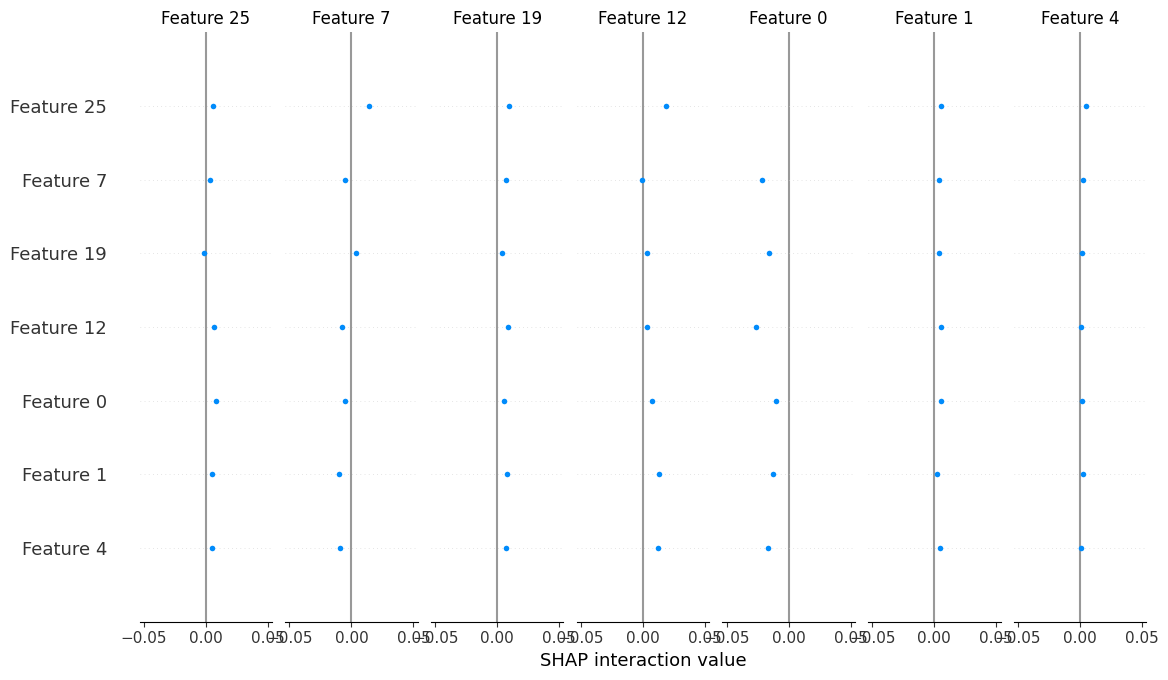

DeltaGenerator()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load your model and the explainer
explainer = shap.GradientExplainer(predict_model, data=X_train_tensor)  # Use a subset of training data to initialize
shap_values = explainer.shap_values(X_test_tensor[0:1])  # Explain a single prediction
pyplot(shap.summary_plot(shap_values, X_test_tensor[0:1]))


In [ ]:
def semantic_search(input_embedding, embeddings_database, top_k=1):
    # Calculate cosine similarities
    similarities = np.dot(embeddings_database, input_embedding) / (np.linalg.norm(embeddings_database, axis=1) * np.linalg.norm(input_embedding))
    # Get top_k indices with highest similarity
    top_k_indices = np.argsort(similarities)[-top_k:][::-1]
    return top_k_indices


In [ ]:
explainer = shap.GradientExplainer(predict_model, torch.FloatTensor(embeddings_database[:100]))  # Using first 100 entries for initialization

In [ ]:
# Function to convert a matplotlib figure to a Tkinter image
def fig_to_img(fig):
    # Save the plot to a PNG in memory
    fig.savefig('temp_plot.png', bbox_inches='tight')
    # Open this image in PIL
    pil_img = Image.open('temp_plot.png')
    # Convert to Tkinter format
    tk_img = ImageTk.PhotoImage(pil_img)
    return tk_img

In [ ]:
import tkinter as tk
from tkinter import messagebox, Label
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

In [ ]:
# Tkinter app setup
app = tk.Tk()
app.title("Disease Predictor")

# Input field for symptoms
symptoms_label = tk.Label(app, text="Enter symptoms:")
symptoms_label.pack()
symptoms_entry = tk.Entry(app, width=50)
symptoms_entry.pack()

# plotting grap from shap
image_label = Label(app)  # We'll update this with the plot images later
image_label.pack()


# Function to handle the 'Diagnose' action
def on_diagnose():
    symptoms = symptoms_entry.get()
    embedding = generate_embeddings(symptoms)
    top_matches = semantic_search(embedding, embeddings_database=None, top_k=1)[0]
    closest_symptom = symptoms_db[top_matches[0]]
    closest_embedding = embeddings_database[top_matches[0]]

    embedding_tensor = torch.FloatTensor([closest_embedding])
    prediction = predict_model(embedding_tensor)
    disease = label_encoder.inverse_transform([prediction.argmax().item()])[0]  # Convert index to disease label
    messagebox.showinfo("Prediction", f"Predicted Disease: {disease}")
    messagebox.showinfo("Top Results",f"closest match Disease: {closest_symptom}")

# Button to trigger diagnosis
diagnose_button = tk.Button(app, text="Diagnose", command=on_diagnose)
diagnose_button.pack()

# Function to handle the 'Show explanation' action
def on_explain():
    embedding_tensor = torch.FloatTensor([generate_embeddings(symptoms_entry.get())])
    shap_values = explainer.shap_values(embedding_tensor)
  # Create a SHAP plot
    fig = shap.summary_plot(shap_values, embedding_tensor.numpy(), show=False)

    # Convert to image and update the image_label
    tk_img = fig_to_img(fig)
    image_label.config(image=tk_img)
    image_label.image = tk_img  # Keep a reference!

explain_button = tk.Button(app, text="Show explanation", command=on_explain)
explain_button.pack()

TclError: no display name and no $DISPLAY environment variable

The code below were created during testing and does not add to the whole system

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Function to calculate metrics and generate confusion matrix
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return precision, recall, f1, conf_matrix

# Function to plot metrics and confusion matrix
def plot_results(results, title_prefix=''):
    fig, axs = plt.subplots(len(results), 2, figsize=(10, 5 * len(results)))
    if len(results) == 1:
        axs = [axs]

    for idx, (noise_level, metrics) in enumerate(sorted(results.items())):
        # Unpack metrics
        svm_metrics, nn_metrics = zip(*metrics)
        svm_accuracy = [m[0] for m in svm_metrics]
        nn_accuracy = [m[1] for m in nn_metrics]

        # Plot accuracy
        axs[idx][0].plot(svm_accuracy, label='SVM Accuracy')
        axs[idx][0].plot(nn_accuracy, label='NN Accuracy')
        axs[idx][0].set_title(f'{title_prefix}Accuracy at Noise Level: {noise_level}')
        axs[idx][0].set_xlabel('Fold Number')
        axs[idx][0].set_ylabel('Accuracy')
        axs[idx][0].legend()

        # Calculate average confusion matrix for Neural Network
        nn_conf_matrices = [calculate_metrics(y_test, m[2])[3] for m in nn_metrics]
        avg_conf_matrix = np.mean(nn_conf_matrices, axis=0)

        # Plot confusion matrix
        sns.heatmap(avg_conf_matrix, annot=True, fmt=".0f", ax=axs[idx][1], cmap='Blues')
        axs[idx][1].set_title(f'{title_prefix}Average Confusion Matrix (NN) at Noise Level: {noise_level}')
        axs[idx][1].set_xlabel('Predicted Label')
        axs[idx][1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
# Prepare Cross Validation
def prepare_cv(data_frame, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    labels = LabelEncoder().fit_transform(data_frame['prognosis'])
    return skf.split(np.stack(data_frame['embeddings'].values), labels)

# Noise Addition
def add_noise(data_frame, level=0.05):
    noisy_data = data_frame.copy()
    noise = np.random.normal(0, level, data_frame.shape)
    noisy_data += noise
    return noisy_data

In [ ]:
# # Modifed the train_eval_models function to calculate additional metrics
# def train_eval_models(data_frame, model, noise_levels=[0.0, 0.05, 0.1], n_splits=5):
#     results = {}
#     for noise_level in noise_levels:
#         metrics_list = []
#         noisy_embeddings = add_noise(np.stack(data_frame['embeddings'].values), noise_level)
#         for train_idx, test_idx in prepare_cv(data_frame, n_splits):
#             X_train, X_test = noisy_embeddings[train_idx], noisy_embeddings[test_idx]
#             y_train, y_test = labels[train_idx], labels[test_idx]
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_test_scaled = scaler.transform(X_test)
#             svm_model = svm.SVC(kernel='linear')
#             svm_model.fit(X_train_scaled, y_train)
#             y_pred_svm = svm_model.predict(X_test_scaled)
#             svm_accuracy, svm_precision, svm_recall, svm_f1, _ = calculate_metrics(y_test, y_pred_svm)
#             nn_model = DiseasePredictor()
#             optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
#             criterion = nn.CrossEntropyLoss()
#             dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train).long())
#             loader = DataLoader(dataset, batch_size=64, shuffle=True)
#             for epoch in range(10):  # Training loop
#                 for inputs, labels in loader:
#                     optimizer.zero_grad()
#                     outputs = nn_model(inputs)
#                     loss = criterion(outputs, labels)
#                     loss.backward()
#                     optimizer.step()
#             nn_predictions = nn_model(torch.tensor(X_test_scaled).float()).argmax(1).numpy()
#             nn_accuracy, nn_precision, nn_recall, nn_f1, _ = calculate_metrics(y_test, nn_predictions)
#             metrics_list.append((svm_accuracy, nn_accuracy, y_test, nn_predictions))
#         results[noise_level] = metrics_list
#     return results




In [ ]:
# Example of running the enhanced script
results = train_eval_models(data_frame, DiseasePredictor(), noise_levels=[0.0, 0.05, 0.1])
plot_results(results, title_prefix='Experiment 1: ')

UnboundLocalError: local variable 'labels' referenced before assignment

In [ ]:
#train_model()


In [ ]:
import numpy as np

# Function to add Gaussian noise
def add_gaussian_noise(data, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=data.shape)
    return data + noise

# Add noise to the original scaled data
noise_level = 0.05  # 5% of the data scale
X_noisy = add_gaussian_noise(X_scaled, noise_level=noise_level)

# Split noisy data
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_encoded, test_size=0.2, random_state=42)

# Retrain SVM with linear kernel on noisy data
svm_model_noisy = svm.SVC(kernel='linear')
svm_model_noisy.fit(X_train_noisy, y_train_noisy)
y_pred_noisy = svm_model_noisy.predict(X_test_noisy)

# Evaluate the noisy model
accuracy_noisy = accuracy_score(y_test_noisy, y_pred_noisy)
classification_rep_noisy = classification_report(y_test_noisy, y_pred_noisy)

# Test SVM with RBF kernel on both original and noisy data
svm_model_rbf = svm.SVC(kernel='rbf')
svm_model_rbf.fit(X_train, y_train)
y_pred_rbf = svm_model_rbf.predict(X_test)

svm_model_rbf_noisy = svm.SVC(kernel='rbf')
svm_model_rbf_noisy.fit(X_train_noisy, y_train_noisy)
y_pred_rbf_noisy = svm_model_rbf_noisy.predict(X_test_noisy)

# Evaluate RBF model on clean data
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
classification_rep_rbf = classification_report(y_test, y_pred_rbf)

# Evaluate RBF model on noisy data
accuracy_rbf_noisy = accuracy_score(y_test_noisy, y_pred_rbf_noisy)
classification_rep_rbf_noisy = classification_report(y_test_noisy, y_pred_rbf_noisy)

# Collect all results for comparison
results = {
    "Linear SVM on Noisy Data": (accuracy_noisy, classification_rep_noisy),
    "RBF SVM on Clean Data": (accuracy_rbf, classification_rep_rbf),
    "RBF SVM on Noisy Data": (accuracy_rbf_noisy, classification_rep_rbf_noisy)
}

results


jfhzs [I 2024-04-20 23:02:52,281] Trial 83 finished with value: 0.6940219402313232 and parameters: {'lr': 0.0006312703277951093, 'num_layers': 3, 'num_units': 462, 'dropout_rate': 0.0015024972313569286, 'decay': 0.9053013456459507, 'num_epochs': 55, 'batch_size': 12}. Best is trial 83 with value: 0.6940219402313232.


Best hyperparameters:  {'lr': 0.0006312703277951093, 'num_layers': 3, 'num_units': 462, 'dropout_rate': 0.0015024972313569286, 'decay': 0.9053013456459507, 'num_epochs': 55, 'batch_size': 12}



In [ ]:
# Cluster embeddings dimensions
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings_database)
clusters = kmeans.labels_

# Use GPT-Neo to describe each cluster
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


this part is still under evaluation on where to use it in final application or not

In [ ]:

def describe_cluster(index):
    cluster_center = kmeans.cluster_centers_[index]
    prompt = f"Describe the following data characteristics in simple terms: {cluster_center.tolist()}"
    inputs = gpt_tokenizer.encode(prompt, return_tensors='pt')
    outputs = gpt_model.generate(inputs, max_length= 9000, num_return_sequences=1)
    return gpt_tokenizer.decode(outputs[0], skip_special_tokens=True)

cluster_descriptions = [describe_cluster(i) for i in range(10)]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


IndexError: index out of range in self

this part is for testing and will not be part of the final application

In [ ]:
# Assume 'disease_model' is your trained model and 'embeddings_database' is available
# Initialize SHAP explainer (should ideally be done outside the main app loop to save resources)

print('Disease Diagnosis from Symptoms')
print('Please enter the symptoms you are experiencing:')
yes = True

while yes:
    symptoms = input("Symptoms")
    explain = ""
    embedding = generate_embeddings(symptoms)
    top_matches = semantic_search(embedding, embeddings_database, top_k=1)
    closest_symptom = symptoms_db[top_matches[0]]
    closest_embedding = embeddings_database[top_matches[0]]

    embedding_tensor = torch.FloatTensor([closest_embedding])
    prediction = predict_model(embedding_tensor)
    disease = label_encoder.inverse_transform([prediction.argmax().item()])[0]

    print(f'Closest Matched Symptom Description: {closest_symptom}')
    print(f'Predicted Disease: {disease}')

    explain = input("do you want explaination: ")
    if explain == "yes":
            # SHAP Value Calculation
          shap_values = explainer.shap_values(embedding_tensor)
          pyplot(shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=['Embedding Dimensions']))
          pyplot(shap.summary_plot(shap_values, X_test_tensor.numpy(), feature_names =['Embedding Dimensions'] ))
          showplot()

Overwriting app.py


this part is just for testing and will not be used in the final code

In [ ]:
# Print some statistics of your data to check if it's loaded and scaled correctly
print("Feature statistics:")
print("Mean:", X_tensor.mean())
print("Std deviation:", X_tensor.std())
print("Max value:", X_tensor.max())
print("Min value:", X_tensor.min())

print("\nLabel distribution:")
print(torch.bincount(y_tensor))


this part is just for testing and will not be used in the final code

In [ ]:
# Print the model architecture
print(model)

# Check if any weights or biases have become NaN or inf
for name, param in model.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"Parameter {name} contains NaN or inf")


this part is just for testing and will not be used in the final code

In [ ]:
# Detailed training loop with debug information
for epoch in range(100):
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if torch.isnan(loss) or loss == 0:
            print(f"NaN or zero loss at epoch {epoch+1}, batch {i+1}")
            print("Outputs:", outputs)
            print("Labels:", labels)
            break  # Break out of the loop to investigate
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


this part is just for testing and will not be used in the final code

In [ ]:
# Check optimizer's current state
print("Optimizer state:", optimizer.state_dict())


this part is just for testing and will not be used in the final code

In [ ]:
# Check dropout rate in the model definition
print("Dropout rate:", model.dropout.p)


Dropout rate: 0.025584912658500554


optuna similar to gridsearch to find best hyperparameters